In [57]:
import pandas as pd
import numpy as np
import os
from collections import OrderedDict

import torch
from torch import nn, optim
import torch.nn.functional as F

# Parse DRF Files to get Relevant Data

In [58]:
def generate_master_df(path, num_races=3):
    '''
        Generate the master dataframe from which we will create our training/testing data
        
        Args:
            path (string): Path to directory containing DRF files to parse
            num_races (int): Number of races to use in each sequence (how many races back
                             are we looking?)
        
        Returns: Dataframe containing all data from each DRF concatted together
    '''
    # Cap num_races
    num_races = min(num_races, 9) # Only have max of 9 prev race's data
    
    # Get all DRF files in data directory
    filenames = [path+file for file in os.listdir(path) if file.endswith(".DRF")]
    
    # Iterate through each file and concat data to master df
    master_df = None
    for ii, file in enumerate(filenames): 
        if ii == 0:
            # First pass through just create master df
            df = pd.read_csv(file, header=None)
            master_df = slice_df(df, num_races)
        else:
            # All other passes, append sliced dataframe to master
            df = pd.read_csv(file, header=None)
            df = slice_df(df, num_races)
            master_df = master_df.append(df, ignore_index=True)
            
    # Drop all rows containing NaN values (these horses didn't have enough prev races)
    return master_df.dropna().reset_index().drop(['index'], axis=1)

def slice_df(df, num_races=3):
    '''
        This will take the 1400 field dataframe created from parsing input file CSVs 
        and cut it down to only include information relevant to training the network
        
        Args:
            df (pd.DataFrame): the unedited, 1400 field dataframe
            num_races (int): the number of races into the past we are gathering data for
            
        Returns:
            pd.DataFrame containing only fields relevant to network training
    '''
    # Define columns to grab
    column_ids = OrderedDict({
        'horse_age': (45,46),
        'horse_name': (44,45),
        'lifetime_starts': (96, 97),
        'lifetime_wins': (97, 98),
        'lifetime_places': (98, 99),
        'lifetime_shows': (99, 100),
        'days_since_prev_race': (265, 265+num_races),
        'distance': (315, 315+num_races),
        'num_entrants': (345, 345+num_races),
        'post_position': (355, 355+num_races),
        'weight': (505, 505+num_races),
        'winner_name': (405, 405+num_races),
        'place_name': (415, 415+num_races),
        'show_name': (425, 425+num_races),
        'label': (1035, 1035+num_races) # Finish time
    })

    # Select all of our column ranges
    rng = []
    col_names = []
    for k,v in column_ids.items():
        # Append range to rng -- special case for single field
        if v[1] - v[0] == 1:
            for i in range(num_races):
                rng += [v[0]]
                col_names.append('{}_{}'.format(k, i))
        else:
            # Handle column ranges
            rng += range(v[0],v[1])
            for ii in range(v[0], v[1]):
                col_names.append('{}_{}'.format(k, ii-v[0]))

    # Slice df on columns
    ret = df.loc[:, rng]
    ret.columns = col_names
    return ret

def derive_fields(df, num_races=3):
    '''
        Derive fields such as lifetime wins/places/shows at each race in the past
        and return dataframe containing derived fields, and not containing fields
        required to do derivation.
        
        Args:
            df (pd.DataFrame): DataFrame containing all fields necessary for derivations
            num_races (int): the number of races into the past we are looking (includes today)
            
        Returns:
            pd.DataFrame containing all data required to train network
    '''
    # Can skip Race 0 for all derived metrics since these are already calculated for us in the lifetime
    # stats fields
    drop_columns = []
    for race in range(0, num_races):
        # Calculate starts
        start_col = 'lifetime_starts_{}'.format(race)
        df[start_col] = df['lifetime_starts_0'] - race
        
        # Determine if a horse got win/place/show for previous races
        win_col = 'winner_name_{}'.format(race)
        place_col = 'place_name_{}'.format(race)
        show_col = 'show_name_{}'.format(race)
        horse_name_col = 'horse_name_{}'.format(race)
        
        # Can skip race 0, but still want to remove its intermediate cols
        if race != 0:
            horse_won_col = 'horse_won_{}'.format(race)
            horse_placed_col = 'horse_placed_{}'.format(race)
            horse_showed_col = 'horse_showed_{}'.format(race)

            df[horse_won_col] = df[win_col] == df[horse_name_col]
            df[horse_placed_col] = df[place_col] == df[horse_name_col]
            df[horse_showed_col] = df[show_col] == df[horse_name_col]

            # Calculate point-in-time lifetime stats using the above metrics
            prev_lt_win_col = 'lifetime_wins_{}'.format(race-1)
            lt_win_col = 'lifetime_wins_{}'.format(race)

            prev_lt_place_col = 'lifetime_places_{}'.format(race-1)
            lt_place_col = 'lifetime_places_{}'.format(race)

            prev_lt_show_col = 'lifetime_shows_{}'.format(race-1)
            lt_show_col = 'lifetime_shows_{}'.format(race)

            # If horse won/placed/showed, decrement stats accordingly
            df.loc[df[horse_won_col] == True, lt_win_col] = df[prev_lt_win_col] - 1
            df.loc[df[horse_won_col] == False, lt_win_col] = df[prev_lt_win_col]

            df.loc[df[horse_placed_col] == True, lt_place_col] = df[prev_lt_place_col] - 1
            df.loc[df[horse_placed_col] == False, lt_place_col] = df[prev_lt_place_col]

            df.loc[df[horse_showed_col] == True, lt_show_col] = df[prev_lt_show_col] - 1
            df.loc[df[horse_showed_col] == False, lt_show_col] = df[prev_lt_show_col]
        
            # Append intermediate columns to drop list
            drop_columns += [horse_won_col, horse_placed_col, horse_showed_col, win_col, place_col, show_col, horse_name_col]
        else:
            drop_columns += [win_col, place_col, show_col, horse_name_col]
            
    # Drop unnecessary columns
    df = df.drop(drop_columns, axis=1)
        
        
    return df



In [59]:
pd.set_option('display.max_columns', None) # Remove
days_in_sequence = 3
master_df = generate_master_df('./input_files/', days_in_sequence)
master_df = derive_fields(master_df, days_in_sequence)
master_df.head(5)

,lifetime_shows_0,lifetime_shows_1,lifetime_shows_2,lifetime_wins_0,lifetime_wins_1,lifetime_wins_2,lifetime_starts_0,lifetime_starts_1,lifetime_starts_2,distance_0,distance_1,distance_2,horse_age_0,horse_age_1,horse_age_2,label_0,label_1,label_2,lifetime_places_0,lifetime_places_1,lifetime_places_2,num_entrants_0,num_entrants_1,num_entrants_2,days_since_prev_race_0,days_since_prev_race_1,days_since_prev_race_2,post_position_0,post_position_1,post_position_2,weight_0,weight_1,weight_2
0,0,0,0,0,0,0,10,9,8,1540.0,1320.0,1320.0,13,13,13,89.08,75.17,73.40,1,1,1,7.0,9.0,7.0,16.0,26.0,80.0,4.0,3.0,1.0,119.0,121.0,121.0
1,2,1,1,0,0,0,11,10,9,1320.0,1320.0,1320.0,10,10,10,73.52,75.20,73.53,3,3,2,8.0,8.0,8.0,119.0,14.0,46.0,2.0,3.0,5.0,119.0,124.0,119.0
2,1,1,1,0,0,0,5,4,3,1430.0,1760.0,1320.0,12,12,12,79.60,104.90,75.43,0,0,0,8.0,7.0,9.0,30.0,147.0,17.0,7.0,5.0,1.0,119.0,123.0,121.0
3,0,0,0,0,0,0,10,9,8,1760.0,1760.0,1760.0,13,13,13,103.15,103.83,101.39,2,1,1,7.0,5.0,5.0,22.0,23.0,89.0,1.0,4.0,2.0,121.0,121.0,121.0
4,3,3,2,0,0,0,10,9,8,1430.0,1760.0,1870.0,12,12,12,79.60,96.75,106.14,0,0,0,8.0,7.0,12.0,25.0,63.0,11.0,1.0,7.0,5.0,124.0,123.0,123.0


# Create Dataloader
Create a generator that can parse through the master dataframe, and create batches of training data. These batches will have the shape (days_in_sequence, batch_size, input_features).

In [60]:
import re

# Section off data by race -- list of tuples (race_num, data)
race_data = []
for ii in range(days_in_sequence):
    # Match all collumns for this race
    pattern = re.compile('.*_{}'.format(ii))
    cols = [pattern.match(col).string for col in master_df.columns if pattern.match(col) != None]
    # Get data from these columns
    data = master_df.loc[:, cols]
    # Rename columns
    cols = [col[:-2] for col in cols]
    data.columns = cols
    # Append to race data
    race_data.append((ii, data)) 
    
# Break race_data into input_data and label_data
input_data = []
labels = []
for race_tup in race_data:
    input_data.append(race_tup[1].drop(['label'], axis=1).values)
    labels.append(race_tup[1]['label'].values)
    
# Want data to go in reverse order (oldest races first)
input_data.reverse()
labels.reverse()

In [61]:
def dataloader(data, labels, days_in_sequence=3, batch_size=10, input_features=10):
    # Truncate data to ensure only full batches
    num_horses = len(data[0])
    cutoff = (num_horses//batch_size)*batch_size
    trunc_data = [race[:cutoff] for race in data]
    trunc_labels = [race[:cutoff] for race in labels]
    
    # Create our batches
    for ii in range(0, cutoff, batch_size):
        # Get data for this batch
        batch_data = [race[ii:ii+batch_size] for race in trunc_data]
        batch_labels = [race[ii: ii+batch_size] for race in trunc_labels]
        
        # Create batch tensor of correct size -- days_in_sequence X batch_size X input_features
        batch = torch.zeros((days_in_sequence, batch_size, input_features), dtype=torch.float64)
        
        # Fill in batch tensor
        for batch_col in range(0, batch_size):
            # Create sequence -- grab horse data from each race -- and add to batch
            sequence = torch.tensor([batch_data[i][batch_col] for i in range(0, days_in_sequence)])
            batch[:, batch_col] = sequence
            
        # Create label tensor
        label_tensor = torch.tensor(batch_labels, dtype=torch.float64)
        label_tensor = label_tensor.view(-1)
        
        yield batch, label_tensor
    
    
test = dataloader(input_data, labels)

sample_batch, sample_label = next(iter(dataloader(input_data, labels)))

# Define the Model

In [62]:
class HandicappingBrain(nn.Module):
    
    def __init__(self, input_length=10,lstm_size=64, lstm_layers=1, output_size=1, 
                               drop_prob=0.2):
        super().__init__()
        self.input_length = input_length
        self.output_size = output_size
        self.lstm_size = lstm_size
        self.lstm_layers = lstm_layers
        self.drop_prob = drop_prob
        
        ## LSTM Layer
        self.lstm = nn.LSTM(input_length, lstm_size, lstm_layers, 
                            dropout=drop_prob, batch_first=False)
        
        ## Dropout Layer
        self.dropout = nn.Dropout(drop_prob)
        
        ## Fully-connected Output Layer
        self.fc = nn.Linear(lstm_size, output_size)
      
    
    def forward(self, nn_input, hidden_state):
        '''
            Perform a forward pass through the network
            
            Args:
                nn_input: the batch of input to NN
                hidden_state: The LSTM hidden/cell state tuple
                
            Returns:
                logps: log softmax output
                hidden_state: the updated hidden/cell state tuple
        '''
        # Input -> LSTM
        lstm_out, hidden_state = self.lstm(nn_input, hidden_state)

        # Stack up LSTM outputs -- this gets the final LSTM output for each sequence in the batch
        #lstm_out = lstm_out[-1, :, :]
        lstm_out = lstm_out.contiguous().view(-1, self.lstm_size)
        
        # LSTM -> Dense Layer
        dense_out = self.dropout(self.fc(lstm_out))
        
        # Return the final output and the hidden state
        return dense_out, hidden_state
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data

        hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
              weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())
        
        return hidden

# Test out Model

In [63]:
test_model = HandicappingBrain(input_length=10, lstm_size=8, lstm_layers=1, drop_prob=0.2, output_size=1).double()
hidden = test_model.init_hidden(10)
dense_out, _ = test_model.forward(sample_batch, hidden)
print(dense_out)

tensor([[0.2753],
        [0.2753],
        [0.2753],
        [0.2753],
        [0.0000],
        [0.2753],
        [0.2753],
        [0.2753],
        [0.2753],
        [0.0000],
        [0.0000],
        [0.4328],
        [0.4328],
        [0.4328],
        [0.4328],
        [0.4328],
        [0.4328],
        [0.4328],
        [0.0000],
        [0.4328],
        [0.4570],
        [0.4570],
        [0.0000],
        [0.4570],
        [0.4570],
        [0.4570],
        [0.4570],
        [0.4570],
        [0.4570],
        [0.0000]], dtype=torch.float64, grad_fn=<MulBackward0>)


/Users/nate/anaconda3/envs/julie-stav-ws/lib/python3.5/site-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


# Split Data into Test/Training Sets

In [64]:
test_prop = 0.2
test_end_idx = int(len(input_data[0]) * test_prop)

# Create test set -- test_prob% of our total data set
test_data = [race[:test_end_idx] for race in input_data]
test_labels = [race[:test_end_idx] for race in labels]

# Craete training set
train_data = [race[test_end_idx:] for race in input_data]
train_labels = [race[test_end_idx:] for race in labels]

print(len(train_data[0]), len(train_labels[0]))
print(len(test_data[0]), len(test_labels[0]))

98 98
24 24


# Train the Model

In [65]:
# Train on GPU if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define model -- set dtype to double since our data requires it
model = HandicappingBrain(input_length=10, lstm_size=32, lstm_layers=2, output_size=1, drop_prob=0.3).double()
print(model)

HandicappingBrain(
  (lstm): LSTM(10, 32, num_layers=2, dropout=0.3)
  (dropout): Dropout(p=0.3)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [66]:
epochs = 200
batch_size = 10
learning_rate = 0.003
seq_length = days_in_sequence
clip = 5
input_length = 10

print_every = 2
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

training_losses = [x for x in range(epochs)]
validation_losses = [x for x in range(epochs)]

# Set to training mode
model.train()

for epoch in range(epochs):
    print('Starting Epoch {}'.format(epoch+1))
    batches_processed = 0
    
    # Get batch data
    for batch, labels in dataloader(train_data, train_labels,
                                                input_features=input_length,
                                                days_in_sequence=seq_length,
                                                batch_size=batch_size):
        # Increment step count
        batches_processed += 1
        
        # Initialize hidden state
        train_hidden = model.init_hidden(batch_size)
        train_hidden = tuple([each.data for each in train_hidden])
        
        # Set tensors to correct device
        batch, labels = batch.to(device), labels.to(device)
        for each in train_hidden:
            each.to(device)
            
        # Zero out gradients
        model.zero_grad()
        
        # Run batch data through model
        train_out, train_hidden = model(batch, train_hidden)
        
        # Calculate loss and perform back propogation -- clip gradients if necessary
        loss = criterion(train_out, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        # Take optimizer step to update model weights
        optimizer.step()
        
        # Validation #
        if batches_processed % print_every == 0:
            model.eval()
            val_losses = []
            
            # Iterate through test data to validate model performance
            for val_batch, val_labels in dataloader(test_data, test_labels,
                                                    input_features=input_length,
                                                    days_in_sequence=seq_length,
                                                    batch_size=batch_size):
                # Initialize hidden state
                val_hidden = model.init_hidden(batch_size)
                val_hidden = tuple([each.data for each in val_hidden])
                
                # Set tensors to correct device
                val_batch, val_labels = val_batch.to(device), val_labels.to(device)
                for each in val_hidden:
                    each.to(device)
                    
                # Run data through network
                val_output, val_hidden = model(val_batch, val_hidden)
                
                # Calculate loss
                val_loss = criterion(val_output, val_labels)
                val_losses.append(val_loss.item())
                
            # Print out metrics
            print('Epoch {}/{}...'.format(epoch+1, epochs),
                  'Training Loss {:.6f}...'.format(loss.item()),
                  'Validation Loss: {:.6f}...'.format(np.mean(val_losses)))
            
            # Record metrics
            training_losses[epoch] = loss.item()
            validation_losses[epoch] = np.mean(val_losses)
            
            # Set model back to train
            model.train()

Starting Epoch 1
Epoch 1/200... Training Loss 7718.373092... Validation Loss: 7400.391136...
Epoch 1/200... Training Loss 1483.732470... Validation Loss: 7378.087083...
Epoch 1/200... Training Loss 5334.116757... Validation Loss: 7354.717214...
Epoch 1/200... Training Loss 5176.237009... Validation Loss: 7331.947746...
Starting Epoch 2
Epoch 2/200... Training Loss 7611.927351... Validation Loss: 7292.114497...
Epoch 2/200... Training Loss 1446.767217... Validation Loss: 7260.940358...
Epoch 2/200... Training Loss 5251.581262... Validation Loss: 7226.487272...
Epoch 2/200... Training Loss 5071.086505... Validation Loss: 7189.062649...
Starting Epoch 3
Epoch 3/200... Training Loss 7401.385993... Validation Loss: 7127.838982...
Epoch 3/200... Training Loss 1357.396467... Validation Loss: 7083.204435...
Epoch 3/200... Training Loss 5124.464499... Validation Loss: 7039.740620...
Epoch 3/200... Training Loss 4882.142542... Validation Loss: 6996.594739...
Starting Epoch 4
Epoch 4/200... Train

Epoch 27/200... Training Loss 2465.612250... Validation Loss: 3870.566191...
Epoch 27/200... Training Loss 2973.708617... Validation Loss: 3853.078085...
Starting Epoch 28
Epoch 28/200... Training Loss 4826.110372... Validation Loss: 3825.279467...
Epoch 28/200... Training Loss 715.744401... Validation Loss: 3807.573174...
Epoch 28/200... Training Loss 3119.903269... Validation Loss: 3794.718777...
Epoch 28/200... Training Loss 2168.009933... Validation Loss: 3780.133373...
Starting Epoch 29
Epoch 29/200... Training Loss 4260.093884... Validation Loss: 3755.743461...
Epoch 29/200... Training Loss 673.789222... Validation Loss: 3739.916496...
Epoch 29/200... Training Loss 3268.908709... Validation Loss: 3728.665080...
Epoch 29/200... Training Loss 2382.475899... Validation Loss: 3715.413530...
Starting Epoch 30
Epoch 30/200... Training Loss 4464.111883... Validation Loss: 3692.645405...
Epoch 30/200... Training Loss 454.915926... Validation Loss: 3678.115822...
Epoch 30/200... Training 

Epoch 55/200... Training Loss 2252.489136... Validation Loss: 2452.334616...
Starting Epoch 56
Epoch 56/200... Training Loss 2685.705280... Validation Loss: 2436.310442...
Epoch 56/200... Training Loss 841.135624... Validation Loss: 2425.902225...
Epoch 56/200... Training Loss 2673.724849... Validation Loss: 2418.999681...
Epoch 56/200... Training Loss 1766.208793... Validation Loss: 2410.233750...
Starting Epoch 57
Epoch 57/200... Training Loss 2563.564593... Validation Loss: 2394.376427...
Epoch 57/200... Training Loss 804.342449... Validation Loss: 2384.076577...
Epoch 57/200... Training Loss 2034.583740... Validation Loss: 2377.244748...
Epoch 57/200... Training Loss 1260.064068... Validation Loss: 2368.568150...
Starting Epoch 58
Epoch 58/200... Training Loss 3606.015319... Validation Loss: 2352.873676...
Epoch 58/200... Training Loss 973.094116... Validation Loss: 2342.678288...
Epoch 58/200... Training Loss 2123.283612... Validation Loss: 2335.916686...
Epoch 58/200... Training 

Epoch 83/200... Training Loss 2665.393023... Validation Loss: 1625.373407...
Epoch 83/200... Training Loss 2400.700264... Validation Loss: 1622.733652...
Starting Epoch 84
Epoch 84/200... Training Loss 2567.627888... Validation Loss: 1615.188596...
Epoch 84/200... Training Loss 1336.040929... Validation Loss: 1612.082579...
Epoch 84/200... Training Loss 1632.401998... Validation Loss: 1610.749208...
Epoch 84/200... Training Loss 1393.916478... Validation Loss: 1610.232190...
Starting Epoch 85
Epoch 85/200... Training Loss 1814.293567... Validation Loss: 1605.869524...
Epoch 85/200... Training Loss 1396.971495... Validation Loss: 1604.383298...
Epoch 85/200... Training Loss 1824.549886... Validation Loss: 1604.357726...
Epoch 85/200... Training Loss 1886.401704... Validation Loss: 1605.638308...
Starting Epoch 86
Epoch 86/200... Training Loss 2540.628270... Validation Loss: 1604.299252...
Epoch 86/200... Training Loss 1319.719388... Validation Loss: 1604.356683...
Epoch 86/200... Traini

Epoch 110/200... Training Loss 1431.064261... Validation Loss: 1597.236677...
Epoch 110/200... Training Loss 1362.694434... Validation Loss: 1598.235728...
Starting Epoch 111
Epoch 111/200... Training Loss 2753.937856... Validation Loss: 1590.225221...
Epoch 111/200... Training Loss 1295.020806... Validation Loss: 1588.910303...
Epoch 111/200... Training Loss 1774.795599... Validation Loss: 1591.922122...
Epoch 111/200... Training Loss 1025.295480... Validation Loss: 1597.003734...
Starting Epoch 112
Epoch 112/200... Training Loss 2275.479045... Validation Loss: 1590.198797...
Epoch 112/200... Training Loss 1292.416579... Validation Loss: 1589.879579...
Epoch 112/200... Training Loss 1430.550958... Validation Loss: 1593.821318...
Epoch 112/200... Training Loss 2367.224915... Validation Loss: 1597.826271...
Starting Epoch 113
Epoch 113/200... Training Loss 3230.717545... Validation Loss: 1586.704970...
Epoch 113/200... Training Loss 1324.021593... Validation Loss: 1584.455740...
Epoch 1

Epoch 135/200... Training Loss 2458.445583... Validation Loss: 1491.890505...
Epoch 135/200... Training Loss 681.590621... Validation Loss: 1493.209812...
Starting Epoch 136
Epoch 136/200... Training Loss 2225.932904... Validation Loss: 1489.110151...
Epoch 136/200... Training Loss 1393.008428... Validation Loss: 1487.893442...
Epoch 136/200... Training Loss 899.312428... Validation Loss: 1488.097343...
Epoch 136/200... Training Loss 1185.988315... Validation Loss: 1489.126456...
Starting Epoch 137
Epoch 137/200... Training Loss 2702.649839... Validation Loss: 1486.075965...
Epoch 137/200... Training Loss 1386.842013... Validation Loss: 1485.379886...
Epoch 137/200... Training Loss 2458.094790... Validation Loss: 1486.025888...
Epoch 137/200... Training Loss 1858.488419... Validation Loss: 1487.521433...
Starting Epoch 138
Epoch 138/200... Training Loss 1980.063284... Validation Loss: 1485.275439...
Epoch 138/200... Training Loss 1390.321886... Validation Loss: 1484.975307...
Epoch 138

Starting Epoch 161
Epoch 161/200... Training Loss 3180.736771... Validation Loss: 1481.674289...
Epoch 161/200... Training Loss 1385.912621... Validation Loss: 1481.391540...
Epoch 161/200... Training Loss 1938.234563... Validation Loss: 1482.293202...
Epoch 161/200... Training Loss 2194.664662... Validation Loss: 1483.861317...
Starting Epoch 162
Epoch 162/200... Training Loss 2220.284625... Validation Loss: 1482.108835...
Epoch 162/200... Training Loss 1391.871860... Validation Loss: 1481.998492...
Epoch 162/200... Training Loss 898.944257... Validation Loss: 1483.119584...
Epoch 162/200... Training Loss 1353.898714... Validation Loss: 1484.736330...
Starting Epoch 163
Epoch 163/200... Training Loss 2221.323265... Validation Loss: 1482.701307...
Epoch 163/200... Training Loss 1434.090605... Validation Loss: 1482.434379...
Epoch 163/200... Training Loss 1418.646501... Validation Loss: 1483.505631...
Epoch 163/200... Training Loss 1185.794410... Validation Loss: 1485.144266...
Starting

Epoch 186/200... Training Loss 1402.041700... Validation Loss: 1479.684107...
Epoch 186/200... Training Loss 1938.008192... Validation Loss: 1480.495946...
Epoch 186/200... Training Loss 2194.619284... Validation Loss: 1481.715325...
Starting Epoch 187
Epoch 187/200... Training Loss 3902.300432... Validation Loss: 1479.846976...
Epoch 187/200... Training Loss 1384.809704... Validation Loss: 1479.557609...
Epoch 187/200... Training Loss 1591.652061... Validation Loss: 1480.370300...
Epoch 187/200... Training Loss 1521.969867... Validation Loss: 1481.589694...
Starting Epoch 188
Epoch 188/200... Training Loss 2219.581556... Validation Loss: 1479.721250...
Epoch 188/200... Training Loss 1395.017599... Validation Loss: 1479.420189...
Epoch 188/200... Training Loss 2111.235431... Validation Loss: 1480.218798...
Epoch 188/200... Training Loss 1521.989465... Validation Loss: 1481.426306...
Starting Epoch 189
Epoch 189/200... Training Loss 2219.440275... Validation Loss: 1479.551942...
Epoch 1

In [68]:
hidden = model.init_hidden(10)
dense_out, _ = model.forward(sample_batch, hidden)
print(dense_out)

tensor([[70.8925],
        [70.9378],
        [70.9476],
        [70.9403],
        [70.8437],
        [ 0.0000],
        [ 0.0000],
        [70.9271],
        [70.6423],
        [ 0.0000],
        [ 0.0000],
        [71.0583],
        [ 0.0000],
        [71.0998],
        [ 0.0000],
        [71.0519],
        [ 0.0000],
        [71.0385],
        [71.0181],
        [71.0514],
        [71.0952],
        [71.0707],
        [71.0759],
        [71.0946],
        [71.0591],
        [71.0582],
        [71.0539],
        [ 0.0000],
        [71.1111],
        [ 0.0000]], dtype=torch.float64, grad_fn=<MulBackward0>)


# Plot Training/Validation Loss

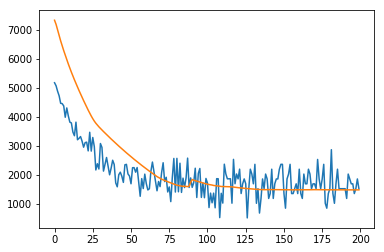

In [67]:
import matplotlib.pyplot as plt

plt.plot(training_losses)
plt.plot(validation_losses)
plt.show()